# STATS 507 Final Project
### Talia Duffy

In [14]:
# Imports

import csv
import pandas as pd
import numpy as np
import transformers
import accelerate
import torch
import matplotlib.pyplot as plt
import math
import nltk

### Data Processing

Here, we convert the full text of *The Picture of Dorian Gray* into sentences. We also keep track of which paragraph (numbered from 0) each sentence belongs to. 

In [15]:
nltk.download("punkt")
nltk.download("punkt_tab")

file_name = "dorian_gray/dorian_gray.txt" # txt file of the novel
file = open(file_name) # open file
text = file.read() # read file

# split text into paragraphs so paragraph number can be counted. In Project Gutenberg txt files, this is indicated by \n\n.
paragraphs = text.split("\n\n") 

sentences = list() # grand list of sentences in the novel
par_count = 0 # keep track of the paragaph number
par_count_column = list() # store paragraph number in a list so it can be placed in a dataframe later

for par in paragraphs: # iterate through each paragraph in the novel.
    clean_par = (par.replace("\n", " ")) # remove line breaks at the end of each line
    # Some txt files (e.g. The Great Gatsby) contain decorative lines like this. They should be removed. 
    clean_par = (par.replace("------------------------------------------------------------------------", "")) 
    par_sentences = nltk.tokenize.sent_tokenize(clean_par) # split the paragraph into list of sentences with nltk model
    par_count_rep = [par_count] * len(par_sentences) # store the paragraph number for each new sentence
    par_count_column = par_count_column + par_count_rep # add paragraph numbers to grand list of paragraph numbers
    sentences = sentences + par_sentences # add sentences from this paragraph to grand list of sentences
    par_count += 1 # move to next paragraph number


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/taliaduffy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/taliaduffy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [16]:
book_sentences = pd.DataFrame() # create empty dataframe
book_sentences["sentences"] = sentences # one row for each sentence in the novel

# Some novels retain linebreak characters in certain sentences. Replace them here.
book_sentences["sentences"] = book_sentences["sentences"].str.replace("\n", " ") 
book_sentences["paragraph"] = par_count_column

# Some novels (e.g. Pride and Prejudice) contain illustrations, which are replaced by lines like [illustration] 
# in the txt file. Nltk puts these into their own "sentences," which should be removed.
book_sentences = book_sentences[~ book_sentences["sentences"].str.contains("\[")]
#book_sentences.to_csv("dorian_gray/dorian_sentences.csv") # save the sentence dataframe in case we need it later.
book_sentences.head(n = 5)

,sentences,paragraph
0,THE PREFACE,0
1,The artist is the creator of beautiful things.,1
2,To reveal art and conceal the artist is art’s ...,1
3,The critic is he who can translate into anothe...,1
4,The highest as the lowest form of criticism is...,2


### The Model: emotion-english-distilroBERTa-base

The following code is largely based on the instructions given by Hartmann for using the model (https://colab.research.google.com/github/j-hartmann/emotion-english-distilroberta-base/blob/main/emotion_prediction_example.ipynb). Some modifications were made for the specifics of this project.

Using the trainer to perform classification allows for greater control and more detailed results.

This model is pretrained and comes with its own tokenizer, and we load them here. We will set up our trainer and training arguments after we further process the tokenized data. 

In [17]:
model_name = "j-hartmann/emotion-english-distilroberta-base" # name of HuggingFace model
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name) # load tokenizer 
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name) # load model

Using this model requires that we create a new dataset class. This allows us to store the tokenized information of our text in a way that's compatible with the model.

In [18]:
# Formats the text data so it can be sent into the model

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

One way to put data into the model is a list of strings. We have already created a list of strings where each element is a sentence in the novel. 

In [19]:
pred_texts = list(book_sentences["sentences"])

The tokenizer breaks down each sentence of the novel into tokens so it can be interpreted by the model. 

The SimpleDataset class we just created gets the token information in the right format. 

In [20]:
# padding = "longest" because we plan to set up dynamic padding with the model training arguments.
# We don't want universal padding. More information on this later in the notebook.

tokenized_sentences = tokenizer(pred_texts, truncation = True, padding = "longest")
tokenized_sentences_dataset = SimpleDataset(tokenized_sentences)

In [21]:
# Inspecting tokenized information

sentence_token_lengths = list() # list of the number of tokens in each sentence
for s in pred_texts:
    token_length = len(tokenizer.encode(s, add_special_tokens=True)) # tokenize each sentence and calculate length
    sentence_token_lengths.append(token_length) # add to list

print("min: " + str(np.min(sentence_token_lengths)))
print("0.25: " + str(np.percentile(sentence_token_lengths, 25)))
print("median: " + str(np.median(sentence_token_lengths)))
print("mean: " + str(np.mean(sentence_token_lengths)))
print("0.75: " + str(np.percentile(sentence_token_lengths, 75)))
print("max: " + str(np.max(sentence_token_lengths)))
print("Longest token lengths: " + str(np.sort(sentence_token_lengths)[::-1][0:10]))

Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors


min: 4
0.25: 11.0
median: 15.0
mean: 18.905544147843944
0.75: 22.0
max: 629
Longest token lengths: [629 282 206 203 200 199 182 172 163 142]


In [22]:
ten_highest = np.sort(sentence_token_lengths)[::-1][0:10]
ten_highest

array([629, 282, 206, 203, 200, 199, 182, 172, 163, 142])

In [23]:
ten_highest_where = np.argsort(sentence_token_lengths)[::-1][0:10]
ten_highest_where

array([3968, 3967, 3821, 3873, 4825, 4500, 3865, 3816,   38, 3803])

In [24]:
print("Longest sentence: " + str(pred_texts[np.argmax(sentence_token_lengths)]))
print("Location of longest sentence: " + str(np.argmax(sentence_token_lengths)))

Longest sentence: Over and over again Dorian used to read this fantastic chapter, and the two chapters immediately following, in which, as in some curious tapestries or cunningly wrought enamels, were pictured the awful and beautiful forms of those whom vice and blood and weariness had made monstrous or mad: Filippo, Duke of Milan, who slew his wife and painted her lips with a scarlet poison that her lover might suck death from the dead thing he fondled; Pietro Barbi, the Venetian, known as Paul the Second, who sought in his vanity to assume the title of Formosus, and whose tiara, valued at two hundred thousand florins, was bought at the price of a terrible sin; Gian Maria Visconti, who used hounds to chase living men and whose murdered body was covered with roses by a harlot who had loved him; the Borgia on his white horse, with Fratricide riding beside him and his mantle stained with the blood of Perotto; Pietro Riario, the young Cardinal Archbishop of Florence, child and minion of S

As you can see, some sentences are quite long. The model struggles with sentences that have a high number of tokens, and this causes extreme inflation in the runtime. The test run of this project was based on lines in the novel, not sentences, and it ran fairly quickly. The longest line was 33 tokens. 

The model makes predictions in batches, and all sentences in the same batch are padded to the same length. So all sentences batched with sentence number 3,968 in *The Picture of Dorian Gray* are padded to an extremely high 629 tokens. The maximum RoBERTa is designed to handle is 512 tokens. 

Let's split (chunk) all sentences longer than 40 tokens (comparable to test of lines with max length 33). Then, we will divide our sentences into two lists: those that already meet the length requirement (short_sentences), and those that had to be chunked (long_sentences). 

Short and long sentences will be predicted separately. For the long sentences, each chunk will be classified separately, and then the results will be aggregated to produce one prediction for the entire sentence. The short sentences will be classified as normal. 

Finally, we will bring all of our results together at the end. 

In [25]:
max_tokens = 40 # define max length as 40 tokens

def chunk_sentence(s, tokenizer = tokenizer, max_tokens = max_tokens): # function to chunk long sentences
    tokenized_s = tokenizer.encode(s, truncation = False) # tokenize the sentence
    chunked_tokens = list() # create empty list to store chunks in token form
    for i in range(0, len(tokenized_s), max_tokens): # Find chunks of length max_tokens
        chunked_tokens.append(tokenized_s[i:i+max_tokens]) # each chunk is an entry in list 
    chunked_s = list() # create emtpy list to store untokenized sentence chunks
    for chunk in chunked_tokens:
        chunked_s.append(tokenizer.decode(chunk, skip_special_tokens=True)) # decode each chunk and add to the list
    return chunked_s # return the sentence in the form of a list, where each element is a segment of text of length max_tokens

In [26]:
short_sentences = list() # create list for short sentences
long_sentences_chunks = list() # create list for long sentences
for idx, s in enumerate(pred_texts): # enumerate through sentences
    token_length = len(tokenizer.tokenize(s)) # number of tokens in each sentence
    if token_length <= max_tokens: # meets length requirement, goes in short sentences
        short_sentences.append(s)
    else:
        # Create a list of lists of chunks.
        long_sentences_chunks.append((idx, chunk_sentence(s))) # keep the index idx so we know which sentence each chunk belongs to.

print("Number of short sentences: " + str(len(short_sentences)))
print("Number of long sentences: " + str(len(long_sentences_chunks))) # helps us gague runtime

Number of short sentences: 6028
Number of long sentences: 303


In [27]:
# Each chunk is like another "short sentence." Finding total number of chunks can give an indication of runtime.

total_chunks = 0
for s in long_sentences_chunks: # iterate through long sentences
    total_chunks += len(s[1]) # accumulate number of chunks
print("Total number of chunks in all long sentences: " + str(total_chunks))

Total number of chunks in all long sentences: 684


In [28]:
# training arguments to control prediction process for short sentences
training_arguments_short = transformers.TrainingArguments(
    output_dir = "tmp",
    # Batching helps runtime. We set up dynamic padding earlier, which means...
    # each short sentence is padded to the length of the longest sentence in its group of 16. 
    # This is in contrast to each sentence being padded to the longest in the entire list.
    per_device_eval_batch_size = 16, 
    dataloader_drop_last = False
)

# create trainer with these args for short sentences.
trainer_short = transformers.Trainer(model = model, args = training_arguments_short) 

In [29]:
# training arguments to control prediction process for long sentences
training_arguments_long = transformers.TrainingArguments(
    output_dir = "tmp",
    # We will see later that each list of chunks is fed into the model separately, so no batching is necessary.
    # One sentence is usually broken up into less chunks than a reasonable batch size would be. 
    per_device_eval_batch_size = 1, 
    dataloader_drop_last = False
)

trainer_long = transformers.Trainer(model = model, args = training_arguments_long)

Finally, we get our predictions for the emotion of each line.

This requires some processing, like using the softmax function to convert the raw scores into probabilities. We also assign an emotion label to each sentence based on whichever emotion had the highest probability. For long sentences, we must also aggregate the results for each chunk and reconstruct the sentence.

We'll store the results and prediction metrics in dataframes.

In [30]:
# padding = longest implements dynamic padding for each batch of 16.
tokenized_short_sentences = tokenizer(short_sentences, truncation = True, padding = "longest")
short_sentences_dataset = SimpleDataset(tokenized_short_sentences) # convert tokenized sentences into the correct form.

In [ ]:
# Make predictions with the model on the dataset of tokenized short sentences

result_short = trainer_short.predict(short_sentences_dataset)

/opt/anaconda3/envs/stats507/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
# Prediction metrics like runtime are helpful to have. Save these.

prediction_metrics_short = result_short.metrics # metrics attribute of the result
df_prediction_metrics_short = pd.DataFrame(prediction_metrics_short, index = [0])
#df_prediction_metrics_short.to_csv("dorian_gray/dorian_gray_metrics_short.csv", index = False)
prediction_metrics_short

{'test_model_preparation_time': 0.0033,
 'test_runtime': 13640.3027,
 'test_samples_per_second': 0.452,
 'test_steps_per_second': 0.028}

In [ ]:
# Saving emotion scores for each sentence

logits_all_short = result_short.predictions

In [ ]:
# The class that was predicted to have the highest value gives us the label for each line
# Use the model's id2label attribute to assign label

preds_short = logits_all_short.argmax(-1)
labels_short = pd.Series(preds_short).map(model.config.id2label)

In [ ]:
softmax = torch.nn.Softmax(dim = -1) # load pytorch softmax fucntion
# use softmax to convert prediction scores for short sentences into probabilities for each emotion
probs_all_short = softmax(torch.tensor(logits_all_short)) 
# Save the probability of the chosen label
label_probs_short = probs_all_short.max(1)

Now onto long sentences. This is a bit more complicated.

In [ ]:
# create dictionary...
# Each key = original sentence index; each value = the logit predictions for each chunk.
long_predictions_raw = {} 
tracker = 0
for idx, chunks in long_sentences_chunks: # iterate through the list of chunked long sentences
    tokenized_chunks = tokenizer(chunks) # tokenize the chunks of each long sentence. No padding because we're not batching.
    tokenized_chunks_dataset = SimpleDataset(tokenized_chunks) # make SimpleDataset of the tokenized chunks 
    result_chunk = trainer_long.predict(tokenized_chunks_dataset) # make predictions for all chunks
    long_predictions_raw[idx] = result_chunk.predictions # save predicitons for each chunk of the sentence in the dictionary

    if tracker in [ # keep track of where we are.
        math.floor(len(long_sentences_chunks)/4), 
        math.floor(len(long_sentences_chunks)/2), 
        math.floor(len(long_sentences_chunks) * (3/4))
    ]: print("quarter checkpoint :)")
    tracker += 1

quarter checkpoint :)


quarter checkpoint :)


quarter checkpoint :)


Here is where we average the chunk results into one result for each long sentence.

Consider a long sentence with two chunks. If the probability for anger in chunk 1 is 0.2 and the probability for anger in chunk 2 is 0.25, the overall probability for anger in the sentence is 0.225.

After taking the mean of the probabilities, we use the results to get our label. 

In [ ]:
long_idx = list(long_predictions_raw.keys()) # index locations of long sentences

# Dictionaries allow us to match each long sentence's average result to its original index in pred_texts.
# This makes it easier to put long and short results together in the original sentence order for our final results dataset.

probs_all_long = dict() # probabilities

preds_long = dict() # 0-6 label
labels_long = dict() # emotion labels
label_probs_long = dict() # probability for the label

for idx, raw_preds in long_predictions_raw.items(): # iterate through the dictionary of chunk predictions
    logits_all_by_chunk = torch.tensor(raw_preds) # make preds into tensor 
    probs_all_by_chunk = softmax(logits_all_by_chunk) # torch softmax function to get probabilities
    
    mean_probs_all = probs_all_by_chunk.mean(axis = 0) # take mean across chunks

    pred = int(mean_probs_all.argmax()) # 0-6 label
    label = pd.Series(pred).map(model.config.id2label) # gets corresponding emotion label of pred
    prob_label = mean_probs_all.max() # saves probability of label (highest probability)

    probs_all_long[idx] = mean_probs_all # add probability tensor to dictionary of probabilities

    preds_long[idx] = pred # add 0-6 prediction to dictionary
    labels_long[idx] = label # add emotion label to dictionary
    label_probs_long[idx] = prob_label # add highest prob to dictionary

In [ ]:
probs_all_final = list() # final list of all probability vectors in original order

preds_final = list() # final list of 0-6 labels in original order
labels_final = list() # final list of emotions in original order
label_probs_final = list() # final list of label probabilities in original order 

short_i = 0 # keep track of the which short sentence we're on

for i in range(len(pred_texts)):
    if i in long_idx: # if the index matches one of the long sentences, add information from the long sentences.

        probs_all_final.append(probs_all_long[i])

        preds_final.append(preds_long[i])
        labels_final.append(labels_long[i].item())
        label_probs_final.append(float(label_probs_long[i]))

    else: # otherwise, add information from the short sentences.

        probs_all_final.append(probs_all_short[short_i])

        preds_final.append(preds_short[short_i])
        labels_final.append(labels_short[short_i])
        label_probs_final.append(float(label_probs_short[0][short_i]))

        short_i += 1 # Then add 1 to move along the list of short sentences.

In [ ]:
anger = []
disgust = []
fear = []
joy = []
neutral = []
sadness = []
surprise = []

# put the probabilities for each emotion into lists
for i in range(len(pred_texts)):
  anger.append(float(probs_all_final[i][0]))
  disgust.append(float(probs_all_final[i][1]))
  fear.append(float(probs_all_final[i][2]))
  joy.append(float(probs_all_final[i][3]))
  neutral.append(float(probs_all_final[i][4]))
  sadness.append(float(probs_all_final[i][5]))
  surprise.append(float(probs_all_final[i][6]))


final_paragraphs = list(book_sentences["paragraph"])

In [ ]:
# put everything together into a dataframe and save the results.

df_result = pd.DataFrame(list(zip(pred_texts,final_paragraphs,preds_final,labels_final,label_probs_final, anger, disgust, fear, joy, neutral, sadness, surprise)), columns=['text','paragraph','pred','label','prob', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])
#df_result.to_csv("dorian_gray/dorian_gray_results.csv", index = False)

Now, we can perform emotional analysis of the novel.

We create a bar chart to display the frequency of different emotions. We create a line graph to display the strength of emotions throughout the novel. 

In [ ]:
emotions = ["neutral", "disgust", "anger", "sadness", "fear", "surprise", "joy"]
colors = ["dimgray", "yellowgreen", "firebrick", "cornflowerblue", "darkorange", "mediumpurple", "gold"]

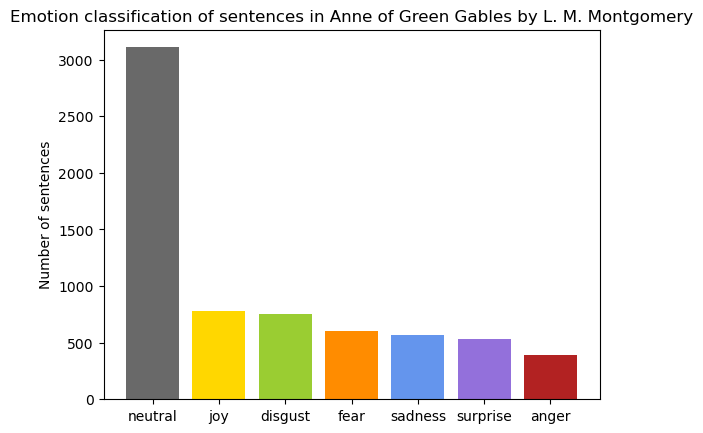

In [ ]:
label_freq = df_result["label"].value_counts()
ordered_emotions = list(label_freq.index)

ordered_colors = list() # automatically order colors
for ordered_emotion in ordered_emotions:
    color_idx = np.where(np.array(emotions) == ordered_emotion)[0][0]
    ordered_colors.append(colors[color_idx])

plt.bar(x = label_freq.index, height = label_freq, color = ordered_colors)
plt.ylabel("Number of sentences")
plt.title("Emotion classification of sentences in the novel")
#plt.savefig("dorian_gray/dorian_gray_barchart.png", bbox_inches = "tight")

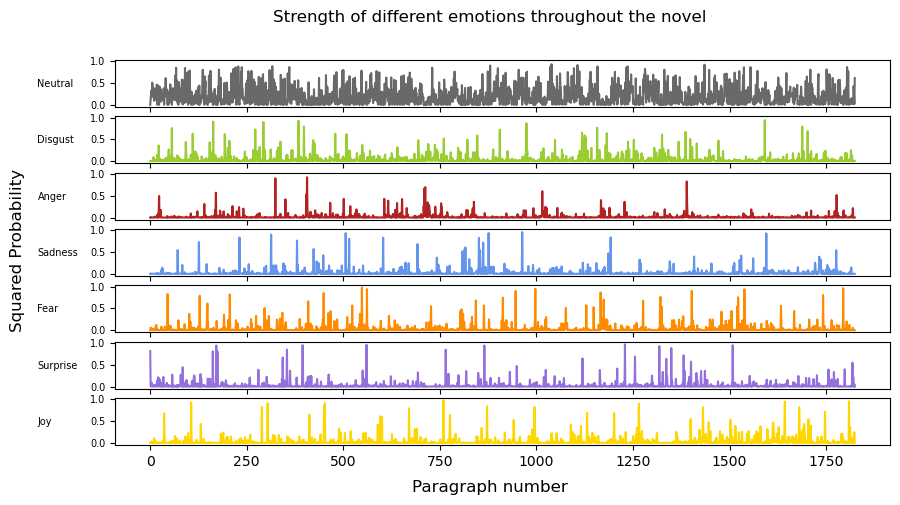

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7)  = plt.subplots(7, sharex = True, sharey = True, figsize = (10,5))
axs = (ax1, ax2, ax3, ax4, ax5, ax6, ax7)
emotions = ["neutral", "disgust", "anger", "sadness", "fear", "surprise", "joy"]
cs = ["dimgray", "yellowgreen", "firebrick", "cornflowerblue", "darkorange", "mediumpurple", "gold"]

fig.suptitle("Strength of different emotions throughout the novel")
for i in range(7):
    emotion = emotions[i]
    ax = axs[i]
    c = cs[i]
    # aggregate by paragraph for visual simplicity (books with many lines would look a mess)
    df_result_par = df_result[["paragraph", emotion]].groupby("paragraph").agg("mean").reset_index()
    ax.plot((df_result_par[emotion])**2, c) # square probability to accentuate spikes in emotion
    ax.set_title(emotion.capitalize(), loc = "left", y = 0.25, x = - 0.1, fontsize = 7)
    ax.set_yticks([0, 0.5, 1])
    ax.tick_params(axis = "y", labelsize = 7)

fig.supxlabel("Paragraph number")
fig.supylabel("Squared Probability")

#plt.savefig("dorian_gray/dorian_gray_linegraph.png", bbox_inches = "tight")